In [1]:
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os


In [4]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=30

In [5]:
datasets=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [6]:
type(datasets)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [7]:
class_names=datasets.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
datasets.element_spec#returns a image and its label

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
for img_batch,img_label in datasets.take(1):
    print(img_batch[0])#1st img in batch 1
    print(img_label.numpy())#all the labels
    print(len(img_batch))
    print(img_batch.shape)

tf.Tensor(
[[[135. 122. 131.]
  [177. 164. 173.]
  [128. 115. 124.]
  ...
  [159. 144. 151.]
  [174. 159. 166.]
  [183. 168. 175.]]

 [[146. 133. 142.]
  [116. 103. 112.]
  [135. 122. 131.]
  ...
  [137. 122. 129.]
  [187. 172. 179.]
  [158. 143. 150.]]

 [[120. 107. 116.]
  [146. 133. 142.]
  [118. 105. 114.]
  ...
  [169. 154. 161.]
  [168. 153. 160.]
  [227. 212. 219.]]

 ...

 [[154. 135. 137.]
  [154. 135. 137.]
  [152. 133. 135.]
  ...
  [147. 126. 133.]
  [174. 153. 160.]
  [189. 168. 175.]]

 [[147. 128. 130.]
  [155. 136. 138.]
  [163. 144. 146.]
  ...
  [146. 125. 132.]
  [140. 119. 126.]
  [132. 111. 118.]]

 [[160. 141. 143.]
  [165. 146. 148.]
  [167. 148. 150.]
  ...
  [144. 123. 130.]
  [125. 104. 111.]
  [188. 167. 174.]]], shape=(256, 256, 3), dtype=float32)
[2 0 1 2 0 1 1 2 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 2 0 1 0 1 0]
32
(32, 256, 256, 3)


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

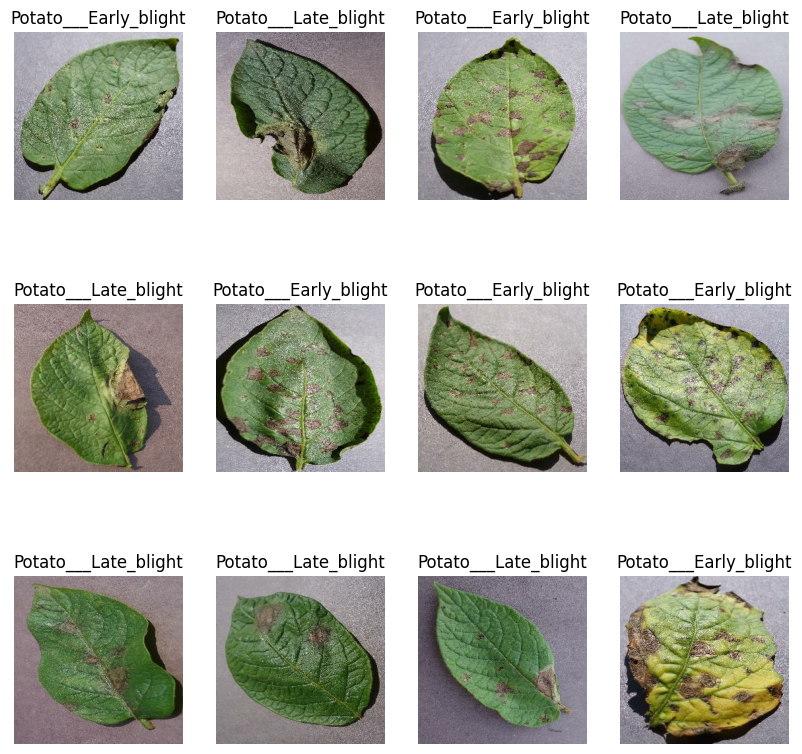

In [10]:
plt.figure(figsize=(10,10))
for image,label in datasets.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

<h3> for training the data 80%->Training<br>20%-> 10%validation on each epoch 10%test</h3>

In [11]:
print(len(datasets))
print(68*32)

68
2176


In [12]:
train_size=0.8
train_num=np.round(len(datasets)*train_size)
train_num


54.0

In [13]:
train_ds=datasets.take(train_num)
len(train_ds)#54 batches

54

In [14]:
val_ds=datasets.skip(train_num).take(np.round(0.1*len(datasets)))
len(val_ds)

7

In [15]:
train_ds=datasets.skip(train_num).skip(np.round(0.1*len(datasets)))
len(train_ds)

7

In [16]:
def get_data_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(datasets)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)

    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds



In [17]:
train_ds,val_ds,test_ds=get_data_partition(datasets)
len(train_ds)

54

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="HORIZONTAL_AND_VERTICAL"),
    tf.keras.layers.RandomRotation(0.2)
])

In [21]:
input_SHAPE=(IMAGE_SIZE,IMAGE_SIZE,3)
model=tf.keras.models.Sequential([

    tf.keras.layers.InputLayer(shape=input_SHAPE),
    resize_and_rescale,
    data_augmentation,


    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])


In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,707 (674.64 KB)

 Trainable params: 172,707 (674.64 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history=model.fit(train_ds,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  verbose=1,
                  validation_data=val_ds
                  )

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 251s 670ms/step - accuracy: 0.4782 - loss: 0.9514 - val_accuracy: 0.4792 - val_loss: 0.8354
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5597 - loss: 0.8204 - val_accuracy: 0.7969 - val_loss: 0.6252
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7511 - loss: 0.6040 - val_accuracy: 0.8490 - val_loss: 0.4296
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8058 - loss: 0.4735 - val_accuracy: 0.7396 - val_loss: 0.6379
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8500 - loss: 0.3805 - val_accuracy: 0.8542 - val_loss: 0.4156
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9215 - loss: 0.2277 - val_accuracy: 0.8125 - val_loss: 0.4613
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9355 - loss: 0.1728 - val_accuracy: 0.7292 - val_loss: 0.9024
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9341 - loss: 0.1744 - val_accuracy: 0.8594 

In [33]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.9626 - loss: 0.1460


[0.08485116809606552, 0.9698275923728943]

In [25]:
history

In [26]:
history.params


{'verbose': 1, 'epochs': 30, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
type(history.history['accuracy'])

list

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9218247532844543,
 0.7633572816848755,
 0.5810568928718567,
 0.5255146622657776,
 0.33461955189704895]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

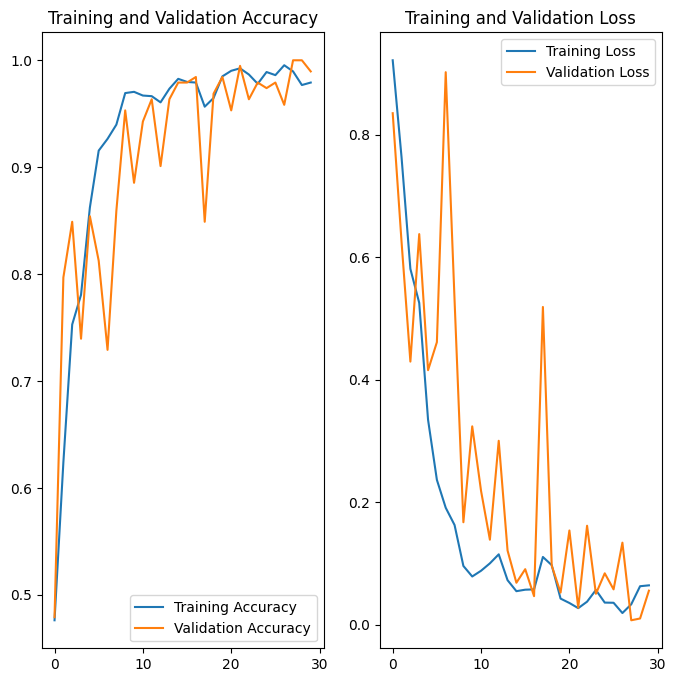

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


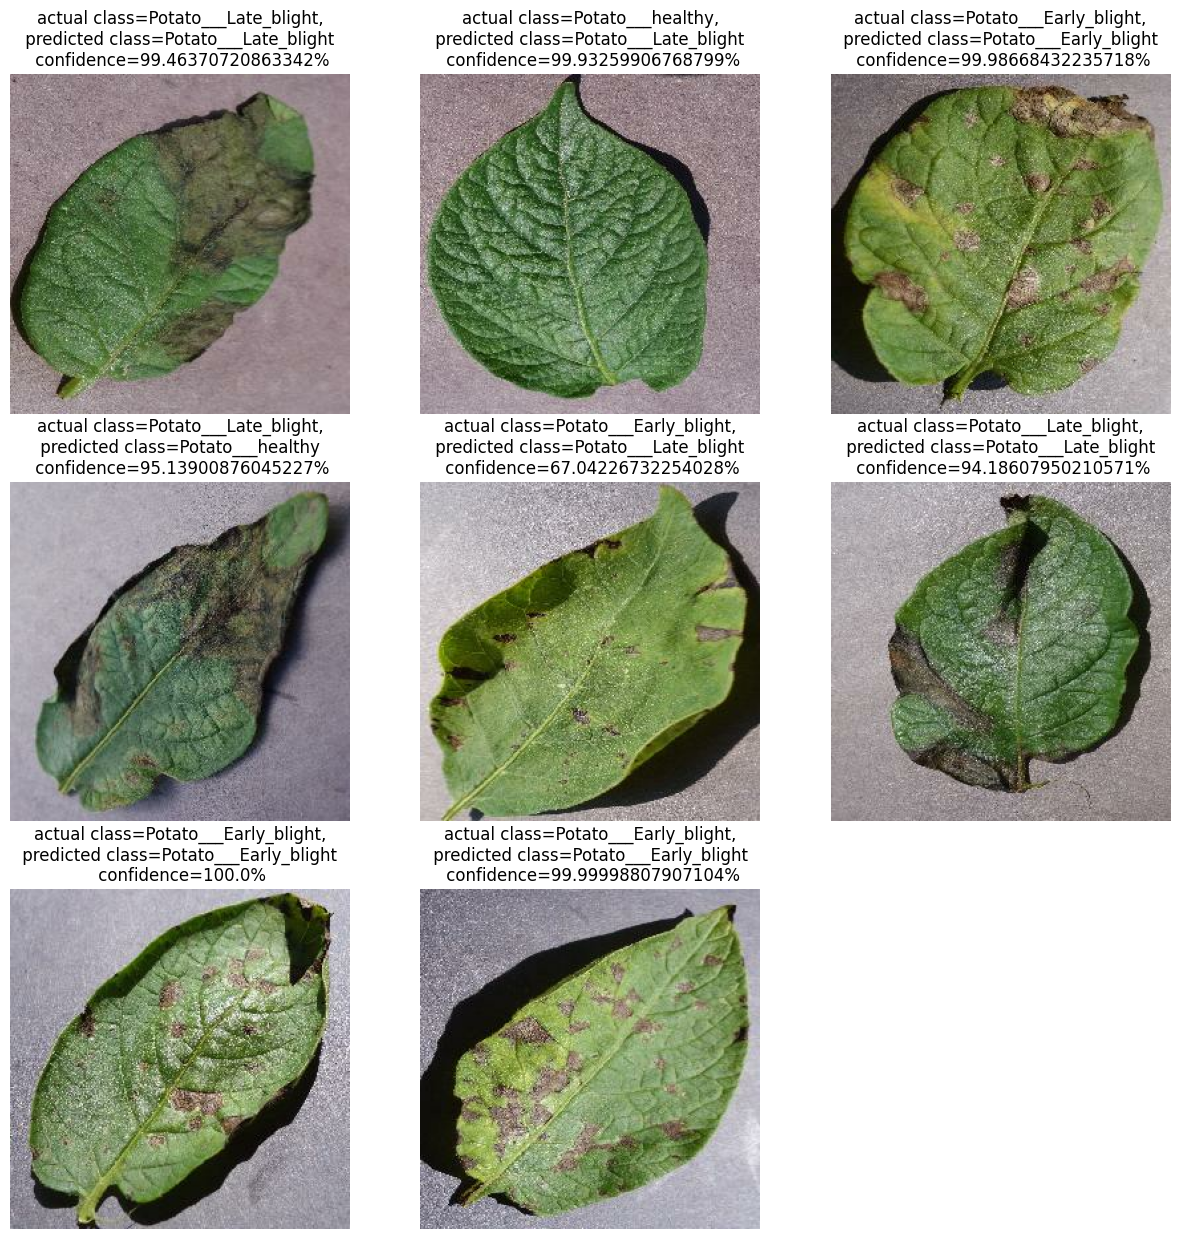

In [42]:
import numpy as np
pred_arr=model.predict(test_ds.take(1))
plt.figure(figsize=(15,15))
for images,label in test_ds.take(1):#in first batch
    for i in range(8):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        plt.title(f"actual class={class_names[label[i]]},\n predicted class={class_names[np.argmax(pred_arr[i])]} \n confidence={np.max(pred_arr[i])*100}%")
        #percentage can be given since its a softamx func()

In [43]:
def predict(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(img)
    #since tensors are in form of(batch_size,img_size,img_size,channels)
    img_arr=tf.expand_dims(img_arr,0)
    predictions=model.predict(img_arr)

    predicted_class=class_names[np.argmax(predictions[0])]
    #since model returns res in form of tensors of form (batch_size,img_size,img_size,channels) therefor predictions[0]
    confidance=round(100*(np.argmax(predictions[0])),2)
    return predicted_class ,confidance


### Saving the Model
We append the model to the list of models as a new version

In [29]:
model.save("../models/potato_model.h5")


In [30]:
model.save("../models/potato_model.keras")